In [2]:
# Importando as bibliotecas necessárias
import pandas as pd
import os
import kagglehub
import shutil
import requests
import gzip
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [13]:
DATASETS = [
    "shivamb/amazon-prime-movies-and-tv-shows",
    "shivamb/disney-movies-and-tv-shows",
    "shivamb/netflix-shows",
]

current_directory = os.getcwd() 
DESTINATION_DIR = os.path.join(current_directory, "data") 

# 1. Cria a pasta 'data' se ela não existir
os.makedirs(DESTINATION_DIR, exist_ok=True)

def download_and_copy_dataset(dataset_name: str, destination_path: str):
    """Baixa um dataset, copia os arquivos para o destino e limpa o cache."""

    # 1. Baixa o dataset para o cache
    try:
        cache_path = kagglehub.dataset_download(dataset_name)
    except Exception as e:
        return

    # 2. Copia os arquivos do cache para o diretório de destino
    for item_name in os.listdir(cache_path):
        source = os.path.join(cache_path, item_name)
        destination = os.path.join(destination_path, item_name)

        # Copia apenas arquivos (ignorando subpastas)
        if os.path.isfile(source):
            shutil.copy2(source, destination) 

    # 3. Remove completamente a pasta do cache
    try:
        shutil.rmtree(cache_path)
    except OSError as e:
        print(f"  > AVISO: Não foi possível remover o cache: {e}")
        
for dataset in DATASETS:
    download_and_copy_dataset(dataset, DESTINATION_DIR)

print("\n\n--- Processo Finalizado ---")
print(f"Todos os arquivos dos datasets estão na pasta: {DESTINATION_DIR}")

100%|██████████| 1.61M/1.61M [00:00<00:00, 1.88MB/s]

Extracting files...


100%|██████████| 131k/131k [00:00<00:00, 345kB/s]

Extracting files...


100%|██████████| 1.34M/1.34M [00:00<00:00, 1.62MB/s]

Extracting files...


--- Processo Finalizado ---
Todos os arquivos dos datasets estão na pasta: d:\Documentos\Trabalho\Ciencia de Dados\CienciaDeDados\TrabalhoFinal\data


In [14]:
def baixar_e_descomprimir_imdb(output_dir="data"):
    """
    Baixa os arquivos de dataset do IMDb e os descomprime.
    Os arquivos são salvos no diretório 'output_dir'.
    """
    
    # URL base dos datasets
    base_url = "https://datasets.imdbws.com/"
    
    # Arquivos necessários para (Nome da Obra, Nota, Diretor)
    files_to_download = [
        "title.basics.tsv.gz",   # Mapeia tconst -> primaryTitle (Nome da Obra)
        "title.ratings.tsv.gz",  # Mapeia tconst -> averageRating (Nota)
        "title.crew.tsv.gz",     # Mapeia tconst -> nconst (ID do Diretor)
        "name.basics.tsv.gz"     # Mapeia nconst -> primaryName (Nome da Pessoa)
    ]
    
    # Cria o diretório de saída se ele não existir
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Diretório criado: '{output_dir}'")

    print("Iniciando downloads... (Isso pode levar vários minutos por arquivo)")

    for filename in files_to_download:
        url = base_url + filename
        
        gz_path = os.path.join(output_dir, filename)
        
        tsv_path = gz_path.replace(".gz", "")
        
        try:
            print(f"\nBaixando: {filename}...")
            with requests.get(url, stream=True) as r:
                r.raise_for_status() # Lança um erro se o status não for 200
                with open(gz_path, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192): 
                        f.write(chunk)
            print("Download concluído.")

            print(f"Descomprimindo: {filename}...")
            with gzip.open(gz_path, 'rb') as f_in:
                with open(tsv_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print(f"Arquivo salvo: {tsv_path}")
            
            os.remove(gz_path)
            print(f"Arquivo temporário '{gz_path}' removido.")

        except requests.exceptions.RequestException as e:
            print(f"\nERRO: Falha ao baixar {url}. Motivo: {e}")
            print("Por favor, verifique sua conexão ou a URL.")
            if os.path.exists(gz_path):
                os.remove(gz_path)
        except Exception as e:
            print(f"\nERRO: Ocorreu um problema: {e}")

    print(f"\nProcesso concluído! Os arquivos TSV estão em: '{output_dir}'")

baixar_e_descomprimir_imdb()

Iniciando downloads... (Isso pode levar vários minutos por arquivo)

Baixando: title.basics.tsv.gz...
Download concluído.
Descomprimindo: title.basics.tsv.gz...
Arquivo salvo: data\title.basics.tsv
Arquivo temporário 'data\title.basics.tsv.gz' removido.

Baixando: title.ratings.tsv.gz...
Download concluído.
Descomprimindo: title.ratings.tsv.gz...
Arquivo salvo: data\title.ratings.tsv
Arquivo temporário 'data\title.ratings.tsv.gz' removido.

Baixando: title.crew.tsv.gz...
Download concluído.
Descomprimindo: title.crew.tsv.gz...
Arquivo salvo: data\title.crew.tsv
Arquivo temporário 'data\title.crew.tsv.gz' removido.

Baixando: name.basics.tsv.gz...
Download concluído.
Descomprimindo: name.basics.tsv.gz...
Arquivo salvo: data\name.basics.tsv
Arquivo temporário 'data\name.basics.tsv.gz' removido.

Processo concluído! Os arquivos TSV estão em: 'data'


In [15]:
#Concatenar as base de dados 

current_directory = os.getcwd() 
DESTINATION_DIR = os.path.join(current_directory, "data") 

df_netflix = pd.read_csv(os.path.join(DESTINATION_DIR, 'netflix_titles.csv'))
df_disney = pd.read_csv(os.path.join(DESTINATION_DIR, 'disney_plus_titles.csv'))
df_amazon = pd.read_csv(os.path.join(DESTINATION_DIR, 'amazon_prime_titles.csv'))

df_netflix['streaming'] = 'Netflix'
df_disney['streaming'] = 'Disney+'
df_amazon['streaming'] = 'Prime Video'

dataframes_to_concat = [df_netflix, df_disney, df_amazon]

df_streaming = pd.concat(dataframes_to_concat, ignore_index=True)

df_streaming['date_added'] = df_streaming['date_added'].str.strip()

df_streaming['date_added'] = pd.to_datetime(df_streaming['date_added'], format='%B %d, %Y')

# Exibindo informações gerais para confirmar a junção e os tipos de dados
print("\nInformações do DataFrame consolidado:")
df_streaming.head(5)


Informações do DataFrame consolidado:


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,streaming
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",Netflix
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",Netflix
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,Netflix
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",Netflix
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,Netflix


In [16]:
genre_mapping = {
    # --- PADRONIZAÇÃO E CONSOLIDAÇÃO (TV/Filmes -> Gênero Principal) ---
    'Dramas': 'Drama', 'TV Dramas': 'Drama',
    'Comedies': 'Comedy', 'TV Comedies': 'Comedy', 'Romantic Comedy': 'Romance , Comedy',
    'Thrillers': 'Thriller', 'TV Thrillers': 'Thriller',
    'Documentaries': 'Documentary', 'Docuseries': 'Documentary',
    'Horror Movies': 'Horror', 'TV Horror': 'Horror',
    'Romantic Movies': 'Romance', 'Romantic TV Shows': 'Romance',
    'International Movies': 'International', 'International TV Shows': 'International',
    'Independent Movies': 'Independent',
    'Sports Movies': 'Sports',
    'Classic Movies': 'Classic',
    'Cult Movies': 'Cult',
    'LGBTQ Movies': 'LGBTQ',
    'Crime TV Shows': 'Crime',
    'Reality TV': 'Reality',
    'Teen TV Shows': 'Teen',
    'TV Mysteries': 'Mystery',
    'Science Fiction': 'Sci-Fi',

    # --- MAPEAMENTO DE SINÔNIMOS E SUB-GÊNEROS ---
    'Anime Features': 'Anime', 'Anime Series': 'Anime',
    "Kids' TV": "Kids", 'Children & Family Movies': 'Kids, Family',
    'Faith and Spirituality': 'Faith & Spirituality',
    'Young Adult Audience': 'Young Adult',
    'Soap Opera / Melodrama': 'Soap Opera',
    'and Culture': 'Culture', 

    # --- SEPARAÇÃO DE GÊNEROS COMPOSTOS (usando vírgula) ---
    'Animals & Nature': 'Nature',
    'Science & Nature': 'Nature, Science', 
    'Arts & Culture': 'Culture, Art',
    'Action & Adventure': 'Action, Adventure',
    'Sci-Fi & Fantasy': 'Sci-Fi, Fantasy',
    'Stand-Up Comedy & Talk Shows': 'Stand-Up Comedy, Talk Show',
    'Music Videos and Concerts': 'Music',
    'Music & Musicals': 'Music, Musical',
    'Science & Nature TV': 'Science, Nature',
    'Animals & Nature': 'Animals, Nature',
    'TV Action & Adventure': 'Action, Adventure',
    'TV Sci-Fi & Fantasy': 'Sci-Fi, Fantasy',
    'Game Show / Competition': 'Game Show, Competition',
    'Action-Adventure': 'Action, Adventure',
    'Classic & Cult TV': 'Classic, Cult',
    'Talk Show and Variety': 'Talk Show, Variety',
    
    # --- Mapeamento direto de gêneros de TV para manter a distinção se desejado ---
    'Korean TV Shows': 'Korean TV',
    'British TV Shows': 'British TV',
    'Spanish-Language TV Shows': 'Spanish TV',

    # --- Remoção de Formatos (não são gêneros temáticos) ---
    'Movies': '_REMOVE_',
    'Series': '_REMOVE_',
    'TV Shows': '_REMOVE_', 
    'TV Show': '_REMOVE_',
    'Anthology': '_REMOVE_',
    'Unscripted': '_REMOVE_', # Categoria muito ampla, coberta por Reality
    'Special Interest': '_REMOVE_' # Categoria muito genérica
}

def process_genres(genre_string):
    """
    Função para aplicar o mapeamento de gênero em uma string 
    que pode conter múltiplos gêneros.
    """
    if pd.isna(genre_string):
        return '' # Retorna string vazia 

    processed_genres = set()
    
    # 1. Separa os gêneros da string original (ex: "TV Dramas, TV Mysteries")
    initial_genres = genre_string.split(',')

    for genre in initial_genres:
        # 2. Limpa o whitespace (ex: " TV Dramas" -> "TV Dramas")
        clean_genre = genre.strip()

        # 3. Aplica o mapping. 
        mapped_value = genre_mapping.get(clean_genre, clean_genre)

        # 4. Processa o valor mapeado
        if mapped_value == '_REMOVE_':
            # Não faz nada, simplesmente ignora o gênero
            continue
        elif ',' in mapped_value:
            # Separa, limpa e adiciona cada sub-gênero
            sub_genres = mapped_value.split(',')
            for sub in sub_genres:
                processed_genres.add(sub.strip())
        else:
            # É um valor único, não vazio e não _REMOVE_
            if mapped_value:
                processed_genres.add(mapped_value)
    
    # ordenados alfabeticamente para consistência.
    return ', '.join(sorted(list(processed_genres)))

df_streaming['genres_processed'] = df_streaming['listed_in'].apply(process_genres)

# 4. (Opcional) Mostra o resultado das 10 primeiras linhas
print("Processamento concluído. Exemplo do resultado:")
print(df_streaming[['listed_in', 'genres_processed']].head(10))

print(df_streaming.dtypes)

Processamento concluído. Exemplo do resultado:
                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   
5                 TV Dramas, TV Horror, TV Mysteries   
6                           Children & Family Movies   
7   Dramas, Independent Movies, International Movies   
8                       British TV Shows, Reality TV   
9                                   Comedies, Dramas   

                          genres_processed  
0                              Documentary  
1            Drama, International, Mystery  
2  Action, Adventure, Crime, International  
3                     Documentary, Reality  
4           Comedy, International, Romance  
5                   Drama, Horror, Mystery  
6                    

In [17]:
output_csv_file = os.path.join('data', 'filmes_series.csv')
df_streaming.to_csv(output_csv_file, index=False)

In [18]:
imdb_data_dir = 'data'
basics_tsv = os.path.join(imdb_data_dir, 'title.basics.tsv')
ratings_tsv = os.path.join(imdb_data_dir, 'title.ratings.tsv')
crew_tsv = os.path.join(imdb_data_dir, 'title.crew.tsv')
names_tsv = os.path.join(imdb_data_dir, 'name.basics.tsv')
movies_csv_file = os.path.join(imdb_data_dir, 'filmes_series.csv')
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

con = duckdb.connect(database=':memory:', read_only=False)

# --- Consulta SQL Principal ---
# Esta consulta é longa, pois prepara e junta 5 arquivos diferentes.
# Consulta desenvolvida com auxilio de IA
merge_query = f"""
WITH
-- 1. Prepara a base de Títulos e Notas do IMDb
imdb_titles_with_rating AS (
    SELECT
        basics.tconst,
        basics.primaryTitle,
        basics.titleType,
        ratings.averageRating,
        TRY_CAST(basics.startYear AS INT64) AS startYear
    FROM read_csv_auto('{basics_tsv}', header=True, delim='\t', quote='', strict_mode=False) AS basics
    JOIN read_csv_auto('{ratings_tsv}', header=True, delim='\t', quote='') AS ratings
        ON basics.tconst = ratings.tconst
    WHERE basics.titleType IN ('movie', 'tvSeries', 'tvMiniSeries', 'tvMovie')
),

-- 2. Prepara a base de Diretores do IMDb 
imdb_director_names AS (
    SELECT
        crew.tconst,
        names.primaryName AS imdb_director_name
    FROM read_csv_auto('{crew_tsv}', header=True, delim='\t', quote='') AS crew
    CROSS JOIN unnest(string_split(crew.directors, ',')) AS t(nconst_id)
    JOIN read_csv_auto('{names_tsv}', header=True, delim='\t', quote='', strict_mode=False) AS names
        ON names.nconst = t.nconst_id
    WHERE t.nconst_id != '\\N'
),

-- 3. Junta Títulos, Notas e Nomes de Diretores do IMDb 
imdb_full_directors AS (
    SELECT
        LOWER(TRIM(t.primaryTitle)) AS imdb_title_clean,
        LOWER(TRIM(d.imdb_director_name)) AS imdb_director_clean,
        t.averageRating AS imdb_rating
    FROM imdb_titles_with_rating AS t
    JOIN imdb_director_names AS d ON t.tconst = d.tconst
    GROUP BY 1, 2, 3
),

-- 4. Prepara a base de dados (sem alteração, com UNION ALL)
netflix_directors_exploded AS (
    SELECT
        n.*, 
        LOWER(TRIM(director_name)) AS director_clean,
        LOWER(TRIM(title)) AS title_clean
    FROM read_csv_auto('{movies_csv_file}', header=True, auto_detect=True) AS n
    CROSS JOIN unnest(string_split(n.director, ',')) AS t(director_name)
    WHERE n.director IS NOT NULL
    UNION ALL
    SELECT
        n.*, 
        NULL AS director_clean, 
        LOWER(TRIM(title)) AS title_clean
    FROM read_csv_auto('{movies_csv_file}', header=True, auto_detect=True) AS n
    WHERE n.director IS NULL
),

-- 5. Prepara a base do IMDb para junção por Título + Ano
imdb_full_year AS (
    SELECT
        LOWER(TRIM(primaryTitle)) AS imdb_title_clean,
        startYear,
        AVG(averageRating) AS imdb_rating -- Média caso haja duplicatas (raro)
    FROM imdb_titles_with_rating
    GROUP BY 1, 2
)


-- 6. Consulta Final: Junta dataset com IMDb 
SELECT
    n.show_id,
    n.type,
    n.title,
    n.director,
    n.cast,
    n.country,
    n.date_added,
    n.release_year,
    n.rating,
    n.duration,
    n.listed_in,
    n.description,
    n.genres_processed,
    n.streaming,
    
    -- COALESCE usa a primeira nota que não for NULA
    COALESCE(
        AVG(i_director.imdb_rating), -- 1ª Tentativa: Título + Diretor
        AVG(i_year.imdb_rating)      -- 2ª Tentativa: Título + Ano
    ) AS imdb_rating_concatenada
    
FROM netflix_directors_exploded AS n
-- JOIN 1: Título + Diretor (Alta Precisão)
LEFT JOIN imdb_full_directors AS i_director
    ON n.title_clean = i_director.imdb_title_clean
    AND n.director_clean = i_director.imdb_director_clean

-- JOIN 2: Título + Ano (Média Precisão)
LEFT JOIN imdb_full_year AS i_year
    ON n.title_clean = i_year.imdb_title_clean
    AND jaro_winkler_similarity(n.title_clean, i_year.imdb_title_clean) > 0.8

GROUP BY
    n.show_id, n.type, n.title, n.director, n.cast, n.country,
    n.date_added, n.release_year, n.rating, n.duration,
    n.listed_in, n.description, n.streaming, n.genres_processed

HAVING
    COALESCE(AVG(i_director.imdb_rating), AVG(i_year.imdb_rating)) IS NOT NULL
"""

print("Executando a consulta de 'merge' (isso pode levar alguns minutos)...")
# Executa a consulta e salva o resultado em um novo CSV
con.execute(f"""
    COPY ({merge_query})
    TO '{output_csv_file}'
    WITH (HEADER 1, DELIMITER ',')
""")
print(f"\nSucesso! Arquivo salvo como: '{output_csv_file}'")

# --- Verificação ---
print("Verificando quantos títulos conseguimos concatenar...")

result = con.execute(f"""
    SELECT
        COUNT(*) AS total_titulos,
        COUNT(imdb_rating_concatenada) AS titulos_com_nota
    FROM read_csv_auto('{output_csv_file}', header=True)
""").df()

total = df_streaming.shape[0]
matched = result['titulos_com_nota'].iloc[0]
percent = (matched / total) * 100 if total > 0 else 0

print("\n--- Relatório de Concatenação ---")
print(f"Total de títulos no seu CSV: {total}")
print(f"Títulos que receberam nota do IMDb: {matched}")
print(f"Taxa de sucesso da concatenação: {percent:.2f}%")

Executando a consulta de 'merge' (isso pode levar alguns minutos)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Sucesso! Arquivo salvo como: 'data\filmes_series_imdb.csv'
Verificando quantos títulos conseguimos concatenar...

--- Relatório de Concatenação ---
Total de títulos no seu CSV: 19925
Títulos que receberam nota do IMDb: 14217
Taxa de sucesso da concatenação: 71.35%


# Etapa 3

### Transformação Tidy

In [19]:
df_streaming.info()

output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')
df_streaming_completo = pd.read_csv(output_csv_file)

#Dividir generos em varios booleanos
df_streaming_completo['genres_processed'] = df_streaming_completo['genres_processed'].fillna('Unknown')
genre_dummies = df_streaming_completo['genres_processed'].str.get_dummies(sep=', ')
genre_dummies = genre_dummies.add_prefix('Genre_')
df_streaming_completo = pd.concat([df_streaming_completo, genre_dummies], axis=1)
df_streaming_completo.to_csv(output_csv_file)

df_streaming_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19925 entries, 0 to 19924
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   show_id           19925 non-null  object        
 1   type              19925 non-null  object        
 2   title             19925 non-null  object        
 3   director          14735 non-null  object        
 4   cast              17677 non-null  object        
 5   country           9879 non-null   object        
 6   date_added        10399 non-null  datetime64[ns]
 7   release_year      19925 non-null  int64         
 8   rating            19581 non-null  object        
 9   duration          19922 non-null  object        
 10  listed_in         19925 non-null  object        
 11  description       19925 non-null  object        
 12  streaming         19925 non-null  object        
 13  genres_processed  19925 non-null  object        
dtypes: datetime64[ns](1), 

In [20]:
def remover_nulos_por_coluna(caminho_csv, nomes_colunas):
    """
    Lê um arquivo CSV e retorna um DataFrame sem as linhas
    onde a 'nomes_colunas' especificada está em branco (NaN ou string vazia).
    """
    try:
        # 1. Lê o arquivo CSV
        df = pd.read_csv(caminho_csv)
    except FileNotFoundError:
        print(f"ERRO: O arquivo '{caminho_csv}' não foi encontrado.")
        return None
    except Exception as e:
        print(f"ERRO ao ler o arquivo: {e}")
        return None

    # 2. Verifica se a coluna existe no DataFrame
    colunas_faltando = [col for col in nomes_colunas if col not in df.columns]
    
    if colunas_faltando:
        print(f"ERRO: As seguintes colunas não foram encontradas: {colunas_faltando}")
        print(f"Colunas disponíveis: {df.columns.to_list()}")
        return None

    # 3. Remove as linhas onde a coluna é Nula (NaN, pd.NA, etc.)
    df_limpo = df.dropna(subset=nomes_colunas)

    # 5. Devolve o DataFrame limpo
    return df_limpo

#Teste
df = remover_nulos_por_coluna(output_csv_file, ['country'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7863 entries, 0 to 14216
Data columns (total 79 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  7863 non-null   int64  
 1   show_id                     7863 non-null   object 
 2   type                        7863 non-null   object 
 3   title                       7863 non-null   object 
 4   director                    5684 non-null   object 
 5   cast                        7272 non-null   object 
 6   country                     7863 non-null   object 
 7   date_added                  7292 non-null   object 
 8   release_year                7863 non-null   int64  
 9   rating                      7848 non-null   object 
 10  duration                    7863 non-null   object 
 11  listed_in                   7863 non-null   object 
 12  description                 7863 non-null   object 
 13  genres_processed            7863 non-

In [25]:
# --- Configuração de Caminhos ---
imdb_data_dir = 'data'
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

print(f"Iniciando processamento da coluna 'country' no arquivo: {output_csv_file}")

# 1. Carrega o DataFrame base
try:
    df_base = pd.read_csv(output_csv_file)
except FileNotFoundError:
    print(f"ERRO: Arquivo '{output_csv_file}' não encontrado. Verifique a conclusão das etapas anteriores.")
    exit()

# 2. Pré-processamento: Trata valores nulos na coluna 'country'
# Preenche NaN para que o get_dummies funcione
df_base['country'] = df_base['country'].fillna('Unknown Country')

# 3. Cria Dummies: Separa os países e cria colunas booleanas
print("Criando colunas dummy para Países...")
country_dummies = df_base['country'].str.get_dummies(sep=', ')
country_dummies = country_dummies.add_prefix('Country_')

# 4. Concatena as Dummies de País com o DataFrame
df_base = pd.concat([df_base, country_dummies], axis=1)
print(f"Total de colunas após adição dos Países: {df_base.shape[1]}")

# 5. Salva o DataFrame ATUALIZADO (sobrescrevendo o arquivo CSV)
df_base.to_csv(output_csv_file, index=False)

print(f"✅ Arquivo CSV atualizado com sucesso. Total de colunas Country_: {country_dummies.shape[1]}")

Iniciando processamento da coluna 'country' no arquivo: data\filmes_series_imdb.csv
Criando colunas dummy para Países...
Total de colunas após adição dos Países: 205
✅ Arquivo CSV atualizado com sucesso. Total de colunas Country_: 126


In [26]:
# --- Configuração de Caminhos ---
imdb_data_dir = 'data'
output_csv_file = os.path.join(imdb_data_dir, 'filmes_series_imdb.csv')

# 1. Carrega o DataFrame base (agora com as colunas Country_ adicionadas pelo script anterior)
try:
    df_base = pd.read_csv(output_csv_file)
except FileNotFoundError:
    print(f"ERRO: Arquivo '{output_csv_file}' não encontrado. Verifique a execução do script de country.")
    exit()


# ----------------------------------------------------------------------
# 2. NORMALIZAÇÃO: Cria Tabelas Long (Alta Cardinalidade)
# ----------------------------------------------------------------------

# --- A. Tabela de Elenco (Cast) Tidy (Formato Long) ---
# Trata Nulos e explode
df_cast = df_base[['show_id', 'cast']].copy()
df_cast['cast'] = df_cast['cast'].fillna('Unknown') 
df_cast['cast_list'] = df_cast['cast'].str.split(', ')
df_actors_tidy = df_cast.explode('cast_list').rename(columns={'cast_list': 'actor_name'})
df_actors_tidy = df_actors_tidy[['show_id', 'actor_name']].drop_duplicates()
print(f"✅ Tabela de Atores (Long) criada: {df_actors_tidy.shape[0]} linhas.")


# --- B. Tabela de Diretores (Director) Tidy (Formato Long) ---
# Trata Nulos e explode
df_director = df_base[['show_id', 'director']].copy()
df_director['director'] = df_director['director'].fillna('Unknown')
df_director['director_list'] = df_director['director'].str.split(', ')
df_directors_tidy = df_director.explode('director_list').rename(columns={'director_list': 'director_name'})
df_directors_tidy = df_directors_tidy[['show_id', 'director_name']].drop_duplicates()
print(f"✅ Tabela de Diretores (Long) criada: {df_directors_tidy.shape[0]} linhas.")


# ----------------------------------------------------------------------
# 3. CRIAÇÃO DA TABELA PRINCIPAL Tidy (Wide)
# ----------------------------------------------------------------------

# Colunas a SEREM REMOVIDAS da Tabela Principal Tidy:
# 'cast', 'director', 'country' são agora redundantes ou foram normalizadas
columns_to_drop = [
    'cast', 'director', 'country', 'listed_in' # 'listed_in' é substituído por 'genres_processed'
]

# Usa .copy() para evitar SettingWithCopyWarning
df_principal_tidy = df_base.drop(columns=columns_to_drop, errors='ignore').copy()

# Remove a coluna temporária 'genres_processed' se preferir usar apenas as Dummies de Gênero
# df_principal_tidy = df_principal_tidy.drop(columns=['genres_processed'], errors='ignore')

# Remove duplicatas baseadas no show_id (caso tenham entrado duplicatas na leitura do CSV)
df_principal_tidy = df_principal_tidy.drop_duplicates(subset=['show_id']).reset_index(drop=True)
print(f"✅ Tabela Principal Tidy (Wide) criada: {df_principal_tidy.shape[0]} linhas, {df_principal_tidy.shape[1]} colunas.")


# ----------------------------------------------------------------------
# 4. EXPORTAÇÃO PARA PARQUET
# ----------------------------------------------------------------------

print("\n📦 Exportando tabelas Tidy para o formato Parquet...")

# Tabela 1: Principal (Wide)
df_principal_tidy.to_parquet(os.path.join(imdb_data_dir, 'principal_tidy.parquet'), index=False)
print("   - principal_tidy.parquet (Tabela Principal com Países/Gêneros Wide)")

# Tabela 2: Diretores (Long)
df_directors_tidy.to_parquet(os.path.join(imdb_data_dir, 'directors_tidy.parquet'), index=False)
print("   - directors_tidy.parquet (Tabela de Diretores Long)")

# Tabela 3: Atores (Long)
df_actors_tidy.to_parquet(os.path.join(imdb_data_dir, 'actors_tidy.parquet'), index=False)
print("   - actors_tidy.parquet (Tabela de Atores Long)")

print("\n🎉 Etapa Tidy Data concluída com sucesso. Seu projeto está pronto para as Consultas SQL!")

✅ Tabela de Atores (Long) criada: 92449 linhas.
✅ Tabela de Diretores (Long) criada: 14822 linhas.
✅ Tabela Principal Tidy (Wide) criada: 8812 linhas, 201 colunas.

📦 Exportando tabelas Tidy para o formato Parquet...
   - principal_tidy.parquet (Tabela Principal com Países/Gêneros Wide)
   - directors_tidy.parquet (Tabela de Diretores Long)
   - actors_tidy.parquet (Tabela de Atores Long)

🎉 Etapa Tidy Data concluída com sucesso. Seu projeto está pronto para as Consultas SQL!


In [29]:
imdb_data_dir = 'data'
principal_parquet = os.path.join(imdb_data_dir, 'principal_tidy.parquet')
directors_parquet = os.path.join(imdb_data_dir, 'directors_tidy.parquet')
actors_parquet = os.path.join(imdb_data_dir, 'actors_tidy.parquet')
output_csv_file = os.path.join(imdb_data_dir, 'principal_tidy.csv')

try:
    # 1. Carrega o arquivo Parquet Principal (Tabela Wide)
    print("Carregando Tabela Principal (Parquet)...")
    df_principal = pd.read_parquet(principal_parquet)

    # 2. Salva a Tabela Principal no formato CSV
    df_principal.to_csv(output_csv_file, index=False)
    print(f"✅ Tabela principal salva como CSV: {output_csv_file}")
    
    # 3. Exibe um preview do DataFrame principal
    print("\n--- Preview da Tabela Principal Tidy (CSV) ---")
    print(df_principal.head())

    # 4. Exibe um preview da Tabela de Diretores (Long)
    print("\n--- Preview da Tabela de Diretores Tidy ---")
    df_directors = pd.read_parquet(directors_parquet)
    print(df_directors.head())
    
except FileNotFoundError as e:
    print(f"\nERRO: Falha ao encontrar o arquivo. O Parquet precisa ser gerado primeiro. {e}")
    print("\nPor favor, execute o código da etapa Tidy anterior ('Código da Etapa Tidy Principal Atualizado') para gerar os arquivos Parquet, e depois execute este código de visualização.")

Carregando Tabela Principal (Parquet)...
✅ Tabela principal salva como CSV: data\principal_tidy.csv

--- Preview da Tabela Principal Tidy (CSV) ---
   Unnamed: 0 show_id   type                       title  date_added  \
0           0   s4397  Movie                   The Giant  2018-11-15   
1           1   s5317  Movie           The Perfect Score        None   
2           2   s6447  Movie                         Sin        None   
3           3   s2672  Movie                 Rising High  2020-04-17   
4           4   s4134  Movie  Await Further Instructions  2019-02-02   

   release_year rating duration  \
0          2017  TV-14  115 min   
1          2004  PG-13   93 min   
2          2021    18+   91 min   
3          2020  TV-MA   95 min   
4          2018  TV-MA   91 min   

                                         description         genres_processed  \
0  In 1843, crippled Martin returns from war to h...     Drama, International   
1  Scarlett Johansson, Erika Christensen, Chri

### Consultas SQL

In [31]:
# 1. Define o diretório e os nomes dos arquivos Parquet
imdb_data_dir = 'data'
principal_parquet = os.path.join(imdb_data_dir, 'principal_tidy.parquet')
directors_parquet = os.path.join(imdb_data_dir, 'directors_tidy.parquet')
actors_parquet = os.path.join(imdb_data_dir, 'actors_tidy.parquet')

# 2. Conecta ao DuckDB
con = duckdb.connect(database=':memory:', read_only=False)

# Função auxiliar para executar e formatar a saída
def run_query(query_title, sql_query):
    print(f"\n--- Consulta: {query_title} ---")
    try:
        result = con.execute(sql_query).fetchdf()
        print(result.to_markdown(index=False, numalign="left", stralign="left"))
    except Exception as e:
        print(f"ERRO ao executar a consulta: {e}")
        print("Verifique se os nomes das colunas e arquivos Parquet estão corretos.")


# -----------------------------------------------------------------------------------------
# 🎯 1. Agregação e Comparação: Média de Nota por Serviço de Streaming
# (Análise Bivariada: streaming vs. imdb_rating_concatenada)
# -----------------------------------------------------------------------------------------
query_1 = f"""
SELECT
    streaming,
    COUNT(show_id) AS total_titulos,
    ROUND(AVG(imdb_rating_concatenada), 2) AS media_imdb_rating
FROM '{principal_parquet}'
GROUP BY 1
ORDER BY media_imdb_rating DESC;
"""
run_query("1. Ranking de Média de Nota por Streaming", query_1)


# -----------------------------------------------------------------------------------------
# 🎯 2. Tendência Temporal: Número de Títulos Lançados por Década
# (Análise Temporal e de Distribuição)
# -----------------------------------------------------------------------------------------
query_2 = f"""
SELECT
    (FLOOR(release_year / 10) * 10) AS decada_lancamento,
    COUNT(show_id) AS total_titulos
FROM '{principal_parquet}'
WHERE release_year IS NOT NULL AND release_year >= 1950
GROUP BY 1
ORDER BY 1;
"""
run_query("2. Tendência de Lançamento por Década", query_2)


# -----------------------------------------------------------------------------------------
# 🎯 3. Ranking com Agregação Complexa: Top 10 Diretores com Mais Títulos e Média de Nota
# (Requer JOIN entre as tabelas Long e Wide)
# -----------------------------------------------------------------------------------------
query_3 = f"""
WITH Director_Stats AS (
    SELECT
        t2.director_name,
        COUNT(t1.show_id) AS num_titulos,
        ROUND(AVG(t1.imdb_rating_concatenada), 2) AS media_rating
    FROM '{principal_parquet}' AS t1
    JOIN '{directors_parquet}' AS t2 ON t1.show_id = t2.show_id
    WHERE t2.director_name != 'Unknown' AND t1.imdb_rating_concatenada IS NOT NULL
    GROUP BY 1
)
SELECT
    *,
    RANK() OVER (ORDER BY num_titulos DESC) AS ranking_volume
FROM Director_Stats
WHERE num_titulos >= 5 -- Filtro para diretores relevantes
ORDER BY num_titulos DESC
LIMIT 10;
"""
run_query("3. Top 10 Diretores (Volume e Média de Nota)", query_3)


# -----------------------------------------------------------------------------------------
# 🎯 4. Correlação: Média de Nota IMDb por Gênero
# (Análise de correlação usando colunas Wide/Dummy)
# -----------------------------------------------------------------------------------------
query_4 = f"""
SELECT
    'Documentary' AS genero,
    ROUND(AVG(CASE WHEN "Genre_Documentary" = 1 THEN imdb_rating_concatenada ELSE NULL END), 2) AS media_rating
FROM '{principal_parquet}'
UNION ALL
SELECT
    'Drama' AS genero,
    ROUND(AVG(CASE WHEN "Genre_Drama" = 1 THEN imdb_rating_concatenada ELSE NULL END), 2) AS media_rating
FROM '{principal_parquet}'
UNION ALL
SELECT
    'Kids' AS genero,
    ROUND(AVG(CASE WHEN "Genre_Kids" = 1 THEN imdb_rating_concatenada ELSE NULL END), 2) AS media_rating
FROM '{principal_parquet}'
ORDER BY media_rating DESC;
"""
run_query("4. Média de Nota dos Gêneros (Documentary, Drama, Kids)", query_4)


# -----------------------------------------------------------------------------------------
# 🎯 5. Análise Bivariada: Países com Maior Nota Média no IMDB
# (Usa as colunas Country_ Dummy para agregar)
# -----------------------------------------------------------------------------------------
query_5 = f"""
SELECT
    'United States' AS country,
    ROUND(AVG(CASE WHEN "Country_United States" = 1 THEN imdb_rating_concatenada ELSE NULL END), 2) AS media_rating
FROM '{principal_parquet}'
UNION ALL
SELECT
    'India' AS country,
    ROUND(AVG(CASE WHEN "Country_India" = 1 THEN imdb_rating_concatenada ELSE NULL END), 2) AS media_rating
FROM '{principal_parquet}'
UNION ALL
SELECT
    'United Kingdom' AS country,
    ROUND(AVG(CASE WHEN "Country_United Kingdom" = 1 THEN imdb_rating_concatenada ELSE NULL END), 2) AS media_rating
FROM '{principal_parquet}'
ORDER BY media_rating DESC;
"""
run_query("5. Média de Nota dos 3 Principais Países de Origem", query_5)

# Fecha a conexão com o DuckDB
con.close()


--- Consulta: 1. Ranking de Média de Nota por Streaming ---
| streaming   | total_titulos   | media_imdb_rating   |
|:------------|:----------------|:--------------------|
| Disney+     | 415             | 6.59                |
| Netflix     | 4459            | 6.4                 |
| Prime Video | 3938            | 5.97                |

--- Consulta: 2. Tendência de Lançamento por Década ---
| decada_lancamento   | total_titulos   |
|:--------------------|:----------------|
| 1950                | 99              |
| 1960                | 91              |
| 1970                | 158             |
| 1980                | 224             |
| 1990                | 467             |
| 2000                | 1050            |
| 2010                | 4809            |
| 2020                | 1762            |

--- Consulta: 3. Top 10 Diretores (Volume e Média de Nota) ---
| director_name       | num_titulos   | media_rating   | ranking_volume   |
|:--------------------|:--------------|:--

### Análise Univariada

In [32]:
# --- Configuração de Caminhos ---
imdb_data_dir = 'data'
principal_parquet = os.path.join(imdb_data_dir, 'principal_tidy.parquet')

# 1. Carrega o DataFrame Principal
try:
    df_principal = pd.read_parquet(principal_parquet)
except Exception as e:
    print(f"ERRO ao carregar o arquivo Parquet: {e}")
    print("Certifique-se de que o arquivo 'principal_tidy.parquet' foi gerado corretamente.")
    exit()

# -----------------------------------------------------------
# I. ANÁLISE DE VARIÁVEIS NUMÉRICAS (Medidas de Tendência Central e Dispersão)
# -----------------------------------------------------------

print("### I. Análise de Variáveis Numéricas (IMDb Rating e Ano de Lançamento) ###")

# 1. Variáveis a serem analisadas
numeric_cols = ['imdb_rating_concatenada', 'release_year']

# 2. Geração da tabela de estatísticas descritivas
stats_descritivas = df_principal[numeric_cols].describe().T

# Adiciona o cálculo da Moda (Mode)
for col in numeric_cols:
    stats_descritivas.loc[col, 'mode'] = df_principal[col].mode()[0]

# Exibe o resultado formatado
print("\n[Medidas de Tendência Central e Dispersão]")
print(stats_descritivas[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'mode']].to_markdown(numalign="left", stralign="left"))


# -----------------------------------------------------------
# II. ANÁLISE DE VARIÁVEIS CATEGÓRICAS (Distribuição de Frequência)
# -----------------------------------------------------------

print("\n### II. Análise de Variáveis Categóricas (Distribuição de Frequência) ###")

# 1. Distribuição de Frequência: Tipo de Título (Movie/TV Show)
print("\n[Distribuição de Frequência: Tipo de Título]")
frequencia_type = df_principal['type'].value_counts(normalize=True).mul(100).round(2).reset_index()
frequencia_type.columns = ['Tipo', 'Porcentagem']
print(frequencia_type.to_markdown(numalign="left", stralign="left"))


# 2. Distribuição de Frequência: Serviço de Streaming
print("\n[Distribuição de Frequência: Serviço de Streaming]")
frequencia_streaming = df_principal['streaming'].value_counts(normalize=True).mul(100).round(2).reset_index()
frequencia_streaming.columns = ['Streaming', 'Porcentagem']
print(frequencia_streaming.to_markdown(numalign="left", stralign="left"))


# 3. Top 5 Gêneros por Contagem (Explorando as Colunas Dummies Wide)
# Conta o total de '1' (presença do gênero) em cada coluna Genre_
print("\n[Distribuição de Frequência: Top 5 Gêneros Mais Frequentes]")
genre_cols = df_principal.filter(like='Genre_').columns
contagem_generos = df_principal[genre_cols].sum().sort_values(ascending=False).reset_index()
contagem_generos.columns = ['Gênero', 'Contagem']
contagem_generos['Gênero'] = contagem_generos['Gênero'].str.replace('Genre_', '')
print(contagem_generos.head(5).to_markdown(numalign="left", stralign="left"))

### I. Análise de Variáveis Numéricas (IMDb Rating e Ano de Lançamento) ###

[Medidas de Tendência Central e Dispersão]
|                         | count   | mean    | std     | min   | 25%   | 50%   | 75%   | max   | mode   |
|:------------------------|:--------|:--------|:--------|:------|:------|:------|:------|:------|:-------|
| imdb_rating_concatenada | 8812    | 6.21549 | 1.21661 | 1     | 5.5   | 6.3   | 7.1   | 9.5   | 6.2    |
| release_year            | 8812    | 2010.45 | 15.525  | 1920  | 2009  | 2016  | 2019  | 2021  | 2020   |

### II. Análise de Variáveis Categóricas (Distribuição de Frequência) ###

[Distribuição de Frequência: Tipo de Título]
|    | Tipo    | Porcentagem   |
|:---|:--------|:--------------|
| 0  | Movie   | 75.85         |
| 1  | TV Show | 24.15         |

[Distribuição de Frequência: Serviço de Streaming]
|    | Streaming   | Porcentagem   |
|:---|:------------|:--------------|
| 0  | Netflix     | 50.6          |
| 1  | Prime Video | 44.69         |

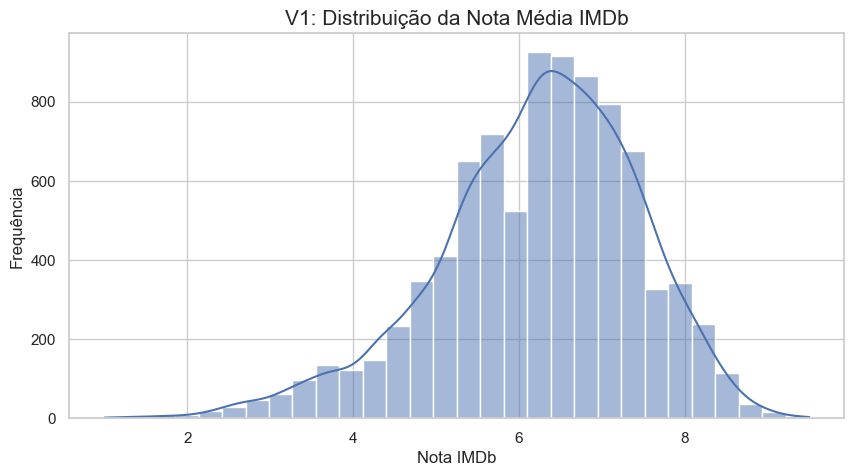

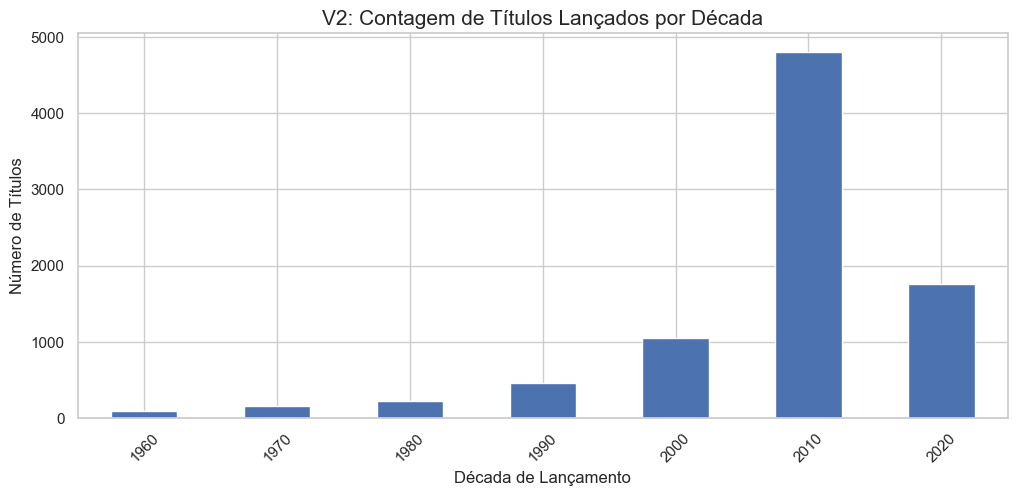

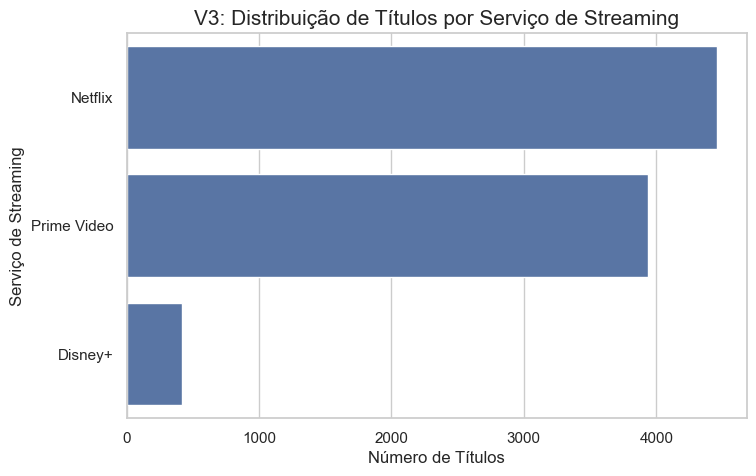

In [ ]:
# --- Configuração de Caminhos (Recomenda-se carregar df_principal aqui) ---
imdb_data_dir = 'data'
principal_parquet = os.path.join(imdb_data_dir, 'principal_tidy.parquet')

# Carrega o DataFrame principal (assumindo que existe)
try:
    df_principal = pd.read_parquet(principal_parquet)
except Exception:
    # Se o carregamento falhar, assumimos que o usuário ajustará o caminho.
    # Para o propósito da resposta, o código de visualização é fornecido.
    pass

# Configuração de estilo visual
sns.set_theme(style="whitegrid")

# --- V1: Distribuição da Nota Média IMDb (Variável Alvo) ---
plt.figure(figsize=(10, 5))
sns.histplot(df_principal['imdb_rating_concatenada'].dropna(), kde=True, bins=30)
plt.title('V1: Distribuição da Nota Média IMDb', fontsize=15)
plt.xlabel('Nota IMDb')
plt.ylabel('Frequência')
plt.show()

# --- V2: Contagem de Títulos Lançados por Década (Variável Temporal) ---
# Filtrando anos razoáveis (a partir de 1950)
df_principal['release_decade'] = (df_principal['release_year'] // 10) * 10
plt.figure(figsize=(12, 5))
df_principal[df_principal['release_decade'] > 1950]['release_decade'].value_counts().sort_index().plot(kind='bar')
plt.title('V2: Contagem de Títulos Lançados por Década', fontsize=15)
plt.xlabel('Década de Lançamento')
plt.ylabel('Número de Títulos')
plt.xticks(rotation=45)
plt.show()

# --- V3: Distribuição de Títulos por Serviço de Streaming (Variável Categórica) ---
plt.figure(figsize=(8, 5))
sns.countplot(y='streaming', data=df_principal, order=df_principal['streaming'].value_counts().index)
plt.title('V3: Distribuição de Títulos por Serviço de Streaming', fontsize=15)
plt.xlabel('Número de Títulos')
plt.ylabel('Serviço de Streaming')
plt.show()

### Análise Bivariada

In [33]:
# --- Configuração de Caminhos ---
imdb_data_dir = 'data'
principal_parquet = os.path.join(imdb_data_dir, 'principal_tidy.parquet')

# 1. Carrega o DataFrame Principal
try:
    df_principal = pd.read_parquet(principal_parquet)
except Exception as e:
    print(f"ERRO ao carregar o arquivo Parquet: {e}")
    print("Certifique-se de que o arquivo 'principal_tidy.parquet' foi gerado corretamente na etapa Tidy.")
    exit()

# Remove Nulos na variável-alvo para análises
df_bivariada = df_principal.dropna(subset=['imdb_rating_concatenada']).copy()


# ----------------------------------------------------------------------------------
# I. Relação entre SERVIÇO DE STREAMING e NOTA IMDb
# ----------------------------------------------------------------------------------

print("### I. Streaming vs. IMDb Rating ###")
streaming_analise = df_bivariada.groupby('streaming')['imdb_rating_concatenada'].agg(
    count='count',
    media='mean',
    mediana='median',
    desvio_padrao='std',
    min_rating='min',
    max_rating='max'
).sort_values(by='media', ascending=False).round(2)

print("\n[Métricas do IMDb Rating por Serviço de Streaming]")
print(streaming_analise.to_markdown(numalign="left", stralign="left"))


# ----------------------------------------------------------------------------------
# II. Relação entre TIPO DE TÍTULO (Movie/TV Show) e NOTA IMDb
# ----------------------------------------------------------------------------------

print("\n### II. Tipo de Título vs. IMDb Rating ###")
type_analise = df_bivariada.groupby('type')['imdb_rating_concatenada'].agg(
    count='count',
    media='mean',
    mediana='median',
    desvio_padrao='std',
).sort_values(by='media', ascending=False).round(2)

print("\n[Métricas do IMDb Rating por Tipo de Título]")
print(type_analise.to_markdown(numalign="left", stralign="left"))


# ----------------------------------------------------------------------------------
# III. Relação entre TOP GÊNEROS e NOTA IMDb
# (Usando as colunas Dummy para comparar a nota média dos títulos que possuem o gênero)
# ----------------------------------------------------------------------------------

print("\n### III. Top Gêneros vs. IMDb Rating ###")

# Seleciona as colunas dummy de Gênero
genre_cols = df_bivariada.filter(like='Genre_').columns

# Cria uma lista para armazenar os resultados
genero_ratings = []

# Analisa o rating médio para os títulos que contêm cada gênero (onde Genre_X == 1)
for col in genre_cols:
    media = df_bivariada[df_bivariada[col] == 1]['imdb_rating_concatenada'].mean()
    contagem = df_bivariada[df_bivariada[col] == 1].shape[0]
    
    if contagem >= 50: # Filtra gêneros com poucas observações
        genero_ratings.append({
            'Gênero': col.replace('Genre_', ''),
            'Média Rating': round(media, 2),
            'Contagem': contagem
        })

df_genero_ratings = pd.DataFrame(genero_ratings).sort_values(by='Média Rating', ascending=False)

print("\n[Top Gêneros por Média de IMDb Rating (Contagem mínima de 50)]")
print(df_genero_ratings.head(10).to_markdown(index=False, numalign="left", stralign="left"))

### I. Streaming vs. IMDb Rating ###

[Métricas do IMDb Rating por Serviço de Streaming]
| streaming   | count   | media   | mediana   | desvio_padrao   | min_rating   | max_rating   |
|:------------|:--------|:--------|:----------|:----------------|:-------------|:-------------|
| Disney+     | 415     | 6.59    | 6.6       | 0.95            | 2.7          | 9.2          |
| Netflix     | 4459    | 6.4     | 6.5       | 1.14            | 1.7          | 9.5          |
| Prime Video | 3938    | 5.97    | 6.1       | 1.28            | 1            | 9.4          |

### II. Tipo de Título vs. IMDb Rating ###

[Métricas do IMDb Rating por Tipo de Título]
| type    | count   | media   | mediana   | desvio_padrao   |
|:--------|:--------|:--------|:----------|:----------------|
| TV Show | 2128    | 6.89    | 6.95      | 1               |
| Movie   | 6684    | 6       | 6.1       | 1.2             |

### III. Top Gêneros vs. IMDb Rating ###

[Top Gêneros por Média de IMDb Rating (Contagem mí

E:\Users\kauma\AppData\Local\Temp\ipykernel_18568\4023770741.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='streaming', y='imdb_rating_concatenada', data=df_bivariada, palette="Set2")


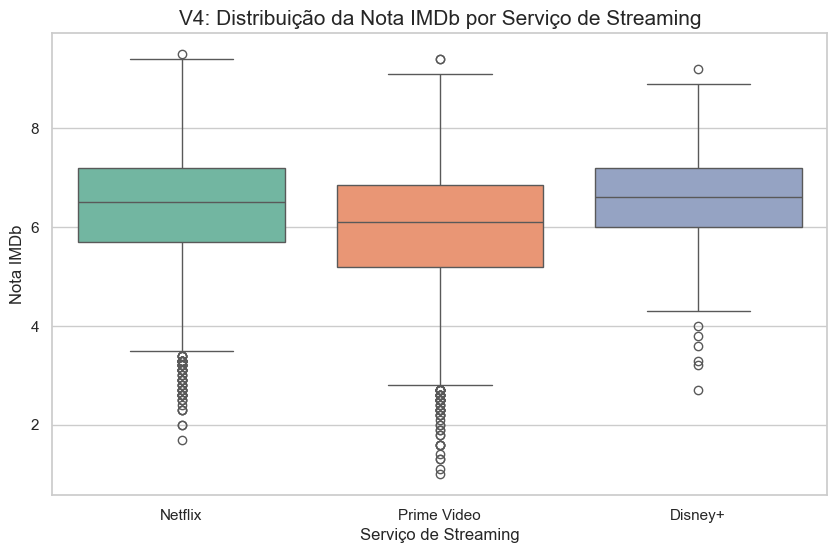

E:\Users\kauma\AppData\Local\Temp\ipykernel_18568\4023770741.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type', y='imdb_rating_concatenada', data=df_bivariada, palette="viridis")


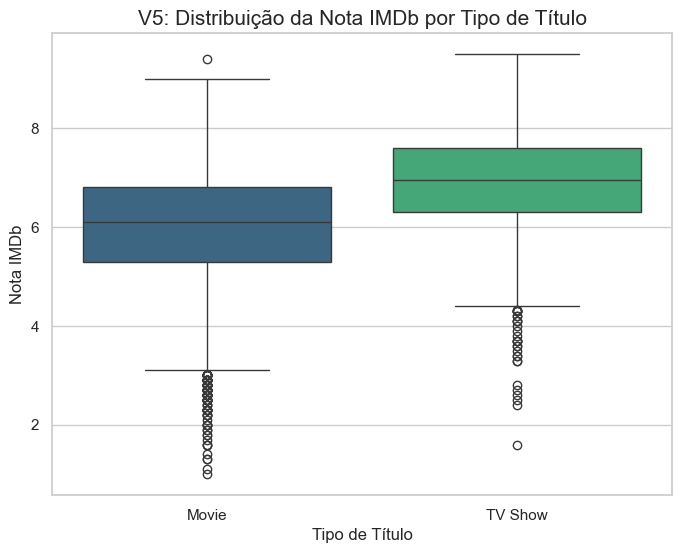

E:\Users\kauma\AppData\Local\Temp\ipykernel_18568\4023770741.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Média Rating', y='Gênero', data=df_genre_ratings, palette="coolwarm")


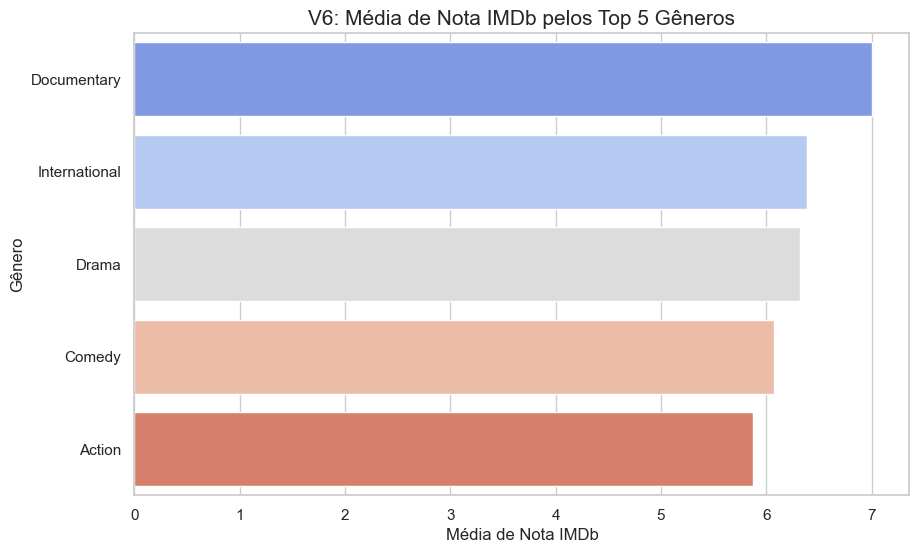

In [40]:
# --- Configuração de Caminhos ---
imdb_data_dir = 'data'
principal_parquet = os.path.join(imdb_data_dir, 'principal_tidy.parquet')

# Carrega o DataFrame principal
try:
    df_principal = pd.read_parquet(principal_parquet)
except Exception:
    # Caso o carregamento falhe no ambiente, o usuário ajustará o caminho
    pass

# DataFrame para análise bivariada (sem nulos no alvo)
df_bivariada = df_principal.dropna(subset=['imdb_rating_concatenada']).copy()

# Configuração de estilo visual
sns.set_theme(style="whitegrid")

# --- V4: Distribuição da Nota IMDb por Serviço de Streaming (Box Plot) ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='streaming', y='imdb_rating_concatenada', data=df_bivariada, palette="Set2")
plt.title('V4: Distribuição da Nota IMDb por Serviço de Streaming', fontsize=15)
plt.xlabel('Serviço de Streaming')
plt.ylabel('Nota IMDb')
plt.show()

# --- V5: Distribuição da Nota IMDb por Tipo de Título (Box Plot) ---
plt.figure(figsize=(8, 6))
sns.boxplot(x='type', y='imdb_rating_concatenada', data=df_bivariada, palette="viridis")
plt.title('V5: Distribuição da Nota IMDb por Tipo de Título', fontsize=15)
plt.xlabel('Tipo de Título')
plt.ylabel('Nota IMDb')
plt.show()

# --- V6: Top 5 Gêneros vs. Média de Nota IMDb (Bar Plot) ---

# 1. Identifica os Top 5 Gêneros por Volume
genre_cols = df_bivariada.filter(like='Genre_').columns
top_genres_by_volume = df_bivariada[genre_cols].sum().sort_values(ascending=False).head(5).index.tolist()

# 2. Calcula a Média de Rating para cada Top Gênero
genre_mean_ratings = []
for col in top_genres_by_volume:
    mean_rating = df_bivariada[df_bivariada[col] == 1]['imdb_rating_concatenada'].mean()
    genre_mean_ratings.append({
        'Gênero': col.replace('Genre_', ''),
        'Média Rating': mean_rating
    })

df_genre_ratings = pd.DataFrame(genre_mean_ratings).sort_values(by='Média Rating', ascending=False)

# 3. Plota o resultado
plt.figure(figsize=(10, 6))
sns.barplot(x='Média Rating', y='Gênero', data=df_genre_ratings, palette="coolwarm")
plt.title('V6: Média de Nota IMDb pelos Top 5 Gêneros', fontsize=15)
plt.xlabel('Média de Nota IMDb')
plt.ylabel('Gênero')
plt.show()

### Análise Multivariada

In [44]:
# --- Configuração de Caminhos ---
imdb_data_dir = 'data'
principal_parquet = os.path.join(imdb_data_dir, 'principal_tidy.parquet')

# 1. Carrega o DataFrame Principal
try:
    df_principal = pd.read_parquet(principal_parquet)
except Exception as e:
    print(f"ERRO ao carregar o arquivo Parquet: {e}")
    print("Certifique-se de que o arquivo 'principal_tidy.parquet' foi gerado corretamente.")
    exit()

# Remove Nulos na variável-alvo
df_multi = df_principal.dropna(subset=['imdb_rating_concatenada']).copy()


# 2. Seleciona as colunas para correlação
# Inclui a variável-alvo (IMDb Rating) e todas as colunas dummy de Gênero/País
correlation_cols = ['imdb_rating_concatenada']
correlation_cols.extend(df_multi.filter(like='Genre_').columns.tolist())
correlation_cols.extend(df_multi.filter(like='Country_').columns.tolist())

df_corr = df_multi[correlation_cols]

# 3. Calcula o Coeficiente de Correlação de Pearson
# A correlação entre uma variável numérica e uma binária (0 ou 1) é válida.
correlation_matrix = df_corr.corr()

# 4. Extrai a correlação da variável-alvo (imdb_rating_concatenada) com todas as outras
imdb_correlations = correlation_matrix['imdb_rating_concatenada'].sort_values(ascending=False)

# Remove a autocorrelação (1.0)
imdb_correlations = imdb_correlations.drop('imdb_rating_concatenada')


# ----------------------------------------------------------------------------------
# 5. Exibe os Resultados (Top 10 Positivos e Negativos)
# ----------------------------------------------------------------------------------

print("### Resultados da Análise Multivariada: Correlação com IMDb Rating ###")

# Top 10 Correlações Positivas (Features que mais aumentam o Rating)
top_positive = imdb_correlations.head(10).reset_index()
top_positive.columns = ['Feature', 'Correlação']
print("\n[Top 10 Correlações POSITIVAS (Maior Peso no Rating)]")
print(top_positive.to_markdown(index=False, numalign="left", stralign="left"))

# Top 10 Correlações Negativas (Features que mais diminuem o Rating)
top_negative = imdb_correlations.tail(10).reset_index()
top_negative.columns = ['Feature', 'Correlação']
print("\n[Top 10 Correlações NEGATIVAS (Menor Peso no Rating)]")
print(top_negative.to_markdown(index=False, numalign="left", stralign="left"))

### Resultados da Análise Multivariada: Correlação com IMDb Rating ###

[Top 10 Correlações POSITIVAS (Maior Peso no Rating)]
| Feature                | Correlação   |
|:-----------------------|:-------------|
| Genre_Documentary      | 0.24102      |
| Genre_Crime            | 0.106515     |
| Country_United States  | 0.101164     |
| Country_United Kingdom | 0.0915225    |
| Genre_Classic          | 0.0908379    |
| Genre_Nature           | 0.0864331    |
| Genre_Anime            | 0.085742     |
| Genre_International    | 0.0850489    |
| Genre_British TV       | 0.0801578    |
| Country_Japan          | 0.0785545    |

[Top 10 Correlações NEGATIVAS (Menor Peso no Rating)]
| Feature                | Correlação   |
|:-----------------------|:-------------|
| Country_Ethiopia       | nan          |
| Country_Kazakhstan     | nan          |
| Country_Lithuania      | nan          |
| Country_Malawi         | nan          |
| Country_Puerto Rico    | nan          |
| Country_Slovakia   

E:\Users\kauma\AppData\Local\Temp\ipykernel_18568\3022493354.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Correlation', y='Feature', data=df_top_corr,


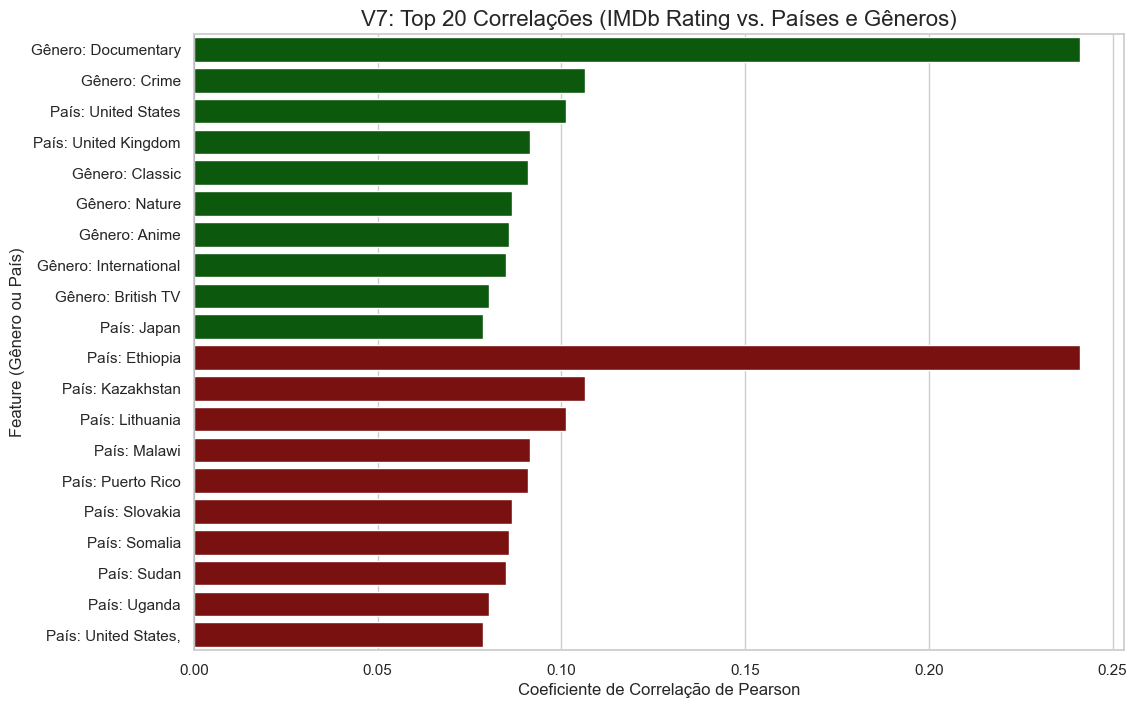

In [45]:
# --- Configuração de Caminhos ---
imdb_data_dir = 'data'
principal_parquet = os.path.join(imdb_data_dir, 'principal_tidy.parquet')

# 1. Carrega o DataFrame principal e prepara para correlação
try:
    df_principal = pd.read_parquet(principal_parquet)
except Exception:
    # Se o carregamento falhar, o usuário ajustará o caminho.
    pass

df_multi = df_principal.dropna(subset=['imdb_rating_concatenada']).copy()

# 2. Seleciona colunas e calcula a Correlação de Pearson com o alvo
correlation_cols = ['imdb_rating_concatenada']
correlation_cols.extend(df_multi.filter(like='Genre_').columns.tolist())
correlation_cols.extend(df_multi.filter(like='Country_').columns.tolist())
df_corr = df_multi[correlation_cols]
correlation_matrix = df_corr.corr()
imdb_correlations = correlation_matrix['imdb_rating_concatenada'].drop('imdb_rating_concatenada').sort_values(ascending=False)

# 3. Prepara dados para plotagem: Top 10 Positivos e Top 10 Negativos
top_positive = imdb_correlations.head(10).reset_index()
top_negative = imdb_correlations.tail(10).reset_index()
df_top_corr = pd.concat([top_positive, top_negative])
df_top_corr.columns = ['Feature', 'Correlation']

# Limpa nomes das features para melhor visualização
df_top_corr['Feature'] = df_top_corr['Feature'].str.replace('Genre_', 'Gênero: ').str.replace('Country_', 'País: ')
df_top_corr = df_top_corr.sort_values(by='Correlation', ascending=False)

# 4. Plotagem dos Top 20 features mais correlacionadas
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# CORREÇÃO: Converte a Series de cores para uma LISTA de Python com .tolist()
cores_personalizadas = df_top_corr['Correlation'].apply(lambda x: 'darkgreen' if x > 0 else 'darkred').tolist()

sns.barplot(x='Correlation', y='Feature', data=df_top_corr, 
            palette=cores_personalizadas) # Usa a lista de cores corrigida

plt.title('V7: Top 20 Correlações (IMDb Rating vs. Países e Gêneros)', fontsize=16)
plt.xlabel('Coeficiente de Correlação de Pearson')
plt.ylabel('Feature (Gênero ou País)')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.show()

### Testes de Hipótese
• H1: Filmes de terror costumam ter uma nota menor que a média

• H2: Filmes no Disney Plus chegam mais rápido ao streaming

• H3: Atores dedicados ao gênero de terror participam de menos produções

In [48]:
# --- Configuração de Caminhos ---
imdb_data_dir = 'data'
principal_parquet = os.path.join(imdb_data_dir, 'principal_tidy.parquet')
actors_parquet = os.path.join(imdb_data_dir, 'actors_tidy.parquet')

# Conecta ao DuckDB
con = duckdb.connect(database=':memory:', read_only=False)

# Função para executar SQL, retornar DataFrame e imprimir o resultado
def run_and_get_df(query_title, sql_query):
    print(f"\n--- Resultados do Teste: {query_title} ---")
    try:
        result = con.execute(sql_query).fetchdf()
        print(result.to_markdown(index=False, numalign="left", stralign="left"))
        return result
    except Exception as e:
        print(f"ERRO: Falha ao executar a pesquisa SQL. Motivo: {e}")
        print("Verifique se os arquivos Parquet foram gerados e o caminho está correto.")
        return None


# -----------------------------------------------------------------------------------------
# H1: Filmes de terror costumam ter uma nota menor que a média
# -----------------------------------------------------------------------------------------
query_h1 = f"""
SELECT 
    ROUND(AVG(imdb_rating_concatenada), 2) AS media_geral_imdb,
    ROUND(AVG(CASE WHEN "Genre_Horror" = 1 THEN imdb_rating_concatenada ELSE NULL END), 2) AS media_horror_imdb
FROM '{principal_parquet}'
WHERE type = 'Movie';
"""
df_h1_raw = run_and_get_df("H1: Nota de Filmes de Terror vs. Média Geral", query_h1)

# -----------------------------------------------------------------------------------------
# H2: Filmes no Disney Plus chegam mais rápido ao streaming
# (Medido pela diferença de anos entre Lançamento e Adição ao Streaming)
# -----------------------------------------------------------------------------------------
query_h2 = f"""
WITH Time_to_Stream AS (
    SELECT
        streaming,
        -- Extrai o ano do campo date_added e subtrai do release_year
        (CAST(SUBSTR(date_added, 1, 4) AS INTEGER) - release_year) AS time_to_stream_years
    FROM '{principal_parquet}'
    WHERE date_added IS NOT NULL AND release_year IS NOT NULL AND type = 'Movie'
)
SELECT
    streaming,
    ROUND(AVG(time_to_stream_years), 2) AS media_tempo_adicao_anos
FROM Time_to_Stream
WHERE streaming IN ('Disney+', 'Netflix', 'Prime Video')
GROUP BY streaming
ORDER BY media_tempo_adicao_anos ASC;
"""
df_h2 = run_and_get_df("H2: Tempo Médio de Adição ao Streaming (Filmes)", query_h2)

# -----------------------------------------------------------------------------------------
# H3: Atores dedicados ao gênero de terror participam de menos produções 
# (Média de Participação de Atores (Terror vs. Todos os Outros))
# -----------------------------------------------------------------------------------------
query_h3_modified = f"""
WITH Actor_Participation AS (
    SELECT
        t2.actor_name,
        COUNT(t1.show_id) AS total_participations,
        -- Indica se o ator participou de algum título de Terror (MAX > 0 implica em True)
        MAX(t1."Genre_Horror") AS is_horror_actor
    FROM '{principal_parquet}' AS t1
    JOIN '{actors_parquet}' AS t2 ON t1.show_id = t2.show_id
    WHERE t2.actor_name != 'Unknown' AND t1.type = 'Movie' -- Focando apenas em Filmes
    GROUP BY t2.actor_name
)
SELECT
    'Atores de Terror' AS grupo_ator,
    ROUND(AVG(total_participations), 2) AS media_titulos_por_ator
FROM Actor_Participation
WHERE is_horror_actor = 1
UNION ALL
SELECT
    'Outros Atores (Não Terror)' AS grupo_ator,
    ROUND(AVG(total_participations), 2) AS media_titulos_por_ator
FROM Actor_Participation
WHERE is_horror_actor = 0 -- Todos os atores que não têm participação no gênero Horror.
"""
df_h3 = run_and_get_df("H3: Média de Participação de Atores (Terror vs. Outros)", query_h3_modified)

con.close()


--- Resultados do Teste: H1: Nota de Filmes de Terror vs. Média Geral ---
| media_geral_imdb   | media_horror_imdb   |
|:-------------------|:--------------------|
| 6                  | 5.01                |

--- Resultados do Teste: H2: Tempo Médio de Adição ao Streaming (Filmes) ---
| streaming   | media_tempo_adicao_anos   |
|:------------|:--------------------------|
| Netflix     | 5.86                      |
| Prime Video | 7.38                      |
| Disney+     | 19.66                     |

--- Resultados do Teste: H3: Média de Participação de Atores (Terror vs. Outros) ---
| grupo_ator                 | media_titulos_por_ator   |
|:---------------------------|:-------------------------|
| Atores de Terror           | 2.66                     |
| Outros Atores (Não Terror) | 1.5                      |


E:\Users\kauma\AppData\Local\Temp\ipykernel_18568\879149062.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Categoria', y='Média Rating', data=df_h1, palette=['grey', 'red'])


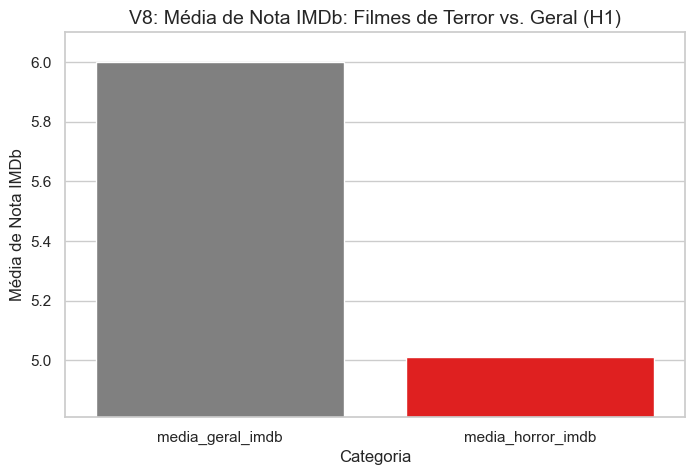

E:\Users\kauma\AppData\Local\Temp\ipykernel_18568\879149062.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='streaming', y='media_tempo_adicao_anos', data=df_h2, palette="muted")


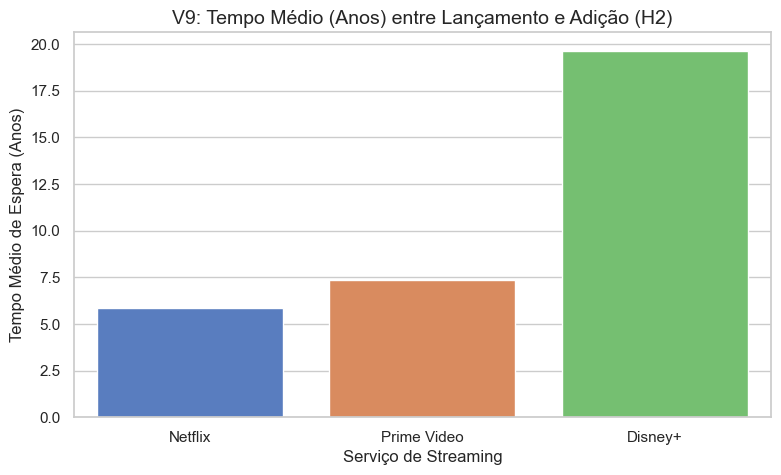

E:\Users\kauma\AppData\Local\Temp\ipykernel_18568\879149062.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='grupo_ator', y='media_titulos_por_ator', data=df_h3, palette=['darkred', 'grey'])


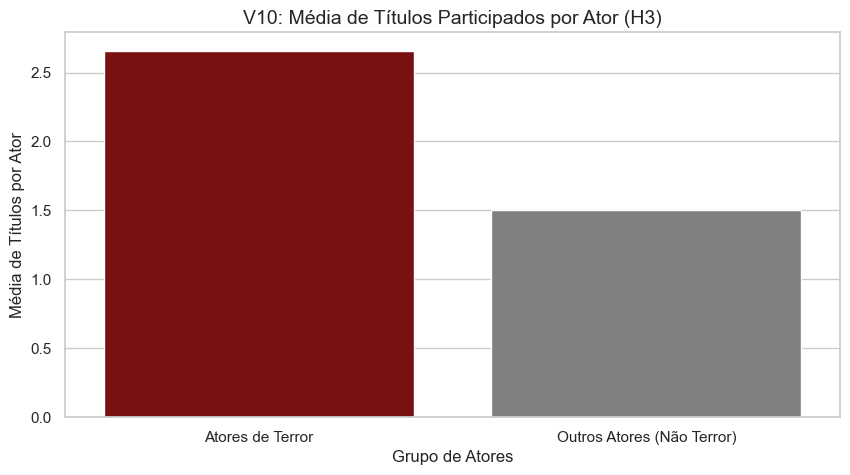

In [49]:
if df_h1_raw is not None:
    df_h1 = df_h1_raw.melt(var_name='Categoria', value_name='Média Rating')
    df_h1['Categoria'] = df_h1['Categoria'].replace({
        'media_geral': 'Média Geral (Filmes)',
        'media_horror': 'Média Terror (Filmes)'
    })
    # Visualização V8
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Categoria', y='Média Rating', data=df_h1, palette=['grey', 'red'])
    plt.title('V8: Média de Nota IMDb: Filmes de Terror vs. Geral (H1)', fontsize=14)
    plt.ylabel('Média de Nota IMDb')
    plt.ylim(df_h1['Média Rating'].min() - 0.2, df_h1['Média Rating'].max() + 0.1) # Ajuste dinâmico
    plt.show()

if df_h2 is not None:
    df_h2 = df_h2.sort_values('media_tempo_adicao_anos', ascending=True)
    plt.figure(figsize=(9, 5))
    sns.barplot(x='streaming', y='media_tempo_adicao_anos', data=df_h2, palette="muted")
    plt.title('V9: Tempo Médio (Anos) entre Lançamento e Adição (H2)', fontsize=14)
    plt.xlabel('Serviço de Streaming')
    plt.ylabel('Tempo Médio de Espera (Anos)')
    plt.show()

if df_h3 is not None:
    df_h3 = df_h3.sort_values('media_titulos_por_ator', ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(x='grupo_ator', y='media_titulos_por_ator', data=df_h3, palette=['darkred', 'grey'])
    plt.title('V10: Média de Títulos Participados por Ator (H3)', fontsize=14)
    plt.xlabel('Grupo de Atores')
    plt.ylabel('Média de Títulos por Ator')
    plt.show()